# 计算位置embeding

In [1]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout, max_len=5000):
        """
        PE(pos,2i) = sin(pos/10000^(2i/d_model))
        PE(pos,2i+1) = cos(pos/10000^(2i/d_model))
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        """
        首先我们初始化一个位置编码索引，形状就是如下参数所示
        其次，我们确定单词位置是先要用索引的，所以需要创建一个 max_len * 1 的矩阵，为啥是这个形状，因为我们要用
        (max_len,1） * (1 * embed_dim)来生成一个可以覆盖那个初始化的位置矩阵
        最后 div_term使用 exp以及后面的math 函数的变换都是为了让位置编码在一个比较合理的范围内，而 range 步长为 2 主要是为了
        分开处理 sin 和 cos 也就是奇数偶数位置
        """
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        """
        最后把pe位置编码矩阵注册成模型的buffer，什么是buffer呢，
        我们把它认为是对模型效果有帮助的，但是却不是模型结构中超参数或者参数，不需要随着优化步骤进行更新的增益对象.
        注册之后我们就可以在模型保存后重加载时和模型结构与参数一同被加载.
        """
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        词 embeding 和位置的 embedding 拼接之前我们对pe做一些适配工作， 将这个三维张量的第二维也就是句子最大长度的那一维切片并
        与输入的x的第二维相同即x.size(1)，因为我们默认max_len为5000一般来讲实在太大了，很难有一条句子包含5000个词汇，
        所以要进行与输入张量的适配.
        最后使用Variable进行封装，使其与x的样式相同，但是它是不需要进行梯度求解的，因此把requires_grad设置成false.
        """
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

# 测试例子

In [7]:
pe = torch.zeros(3, 32)
position = torch.arange(0, 3).unsqueeze(1)
print(position, position.shape) # vacab_len * 1
div_term = torch.exp(torch.arange(0, 32, 2) * -(math.log(10000.0) / 32))
print(div_term, div_term.shape)
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
pe = pe.unsqueeze(0)
print(pe, pe.shape)

tensor([[0],
        [1],
        [2]]) torch.Size([3, 1])
tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04]) torch.Size([16])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  5.3317e-01,  8.4601e-01,  3.1098e-01,
           9.5042e-01,  1.7689e-01,  9.8423e-01,  9.9833e-02,  9.9500e-01,
           5.6204e-02,  9.9842e-01,  3.1618e-02,  9.9950e-01,  1.7782e

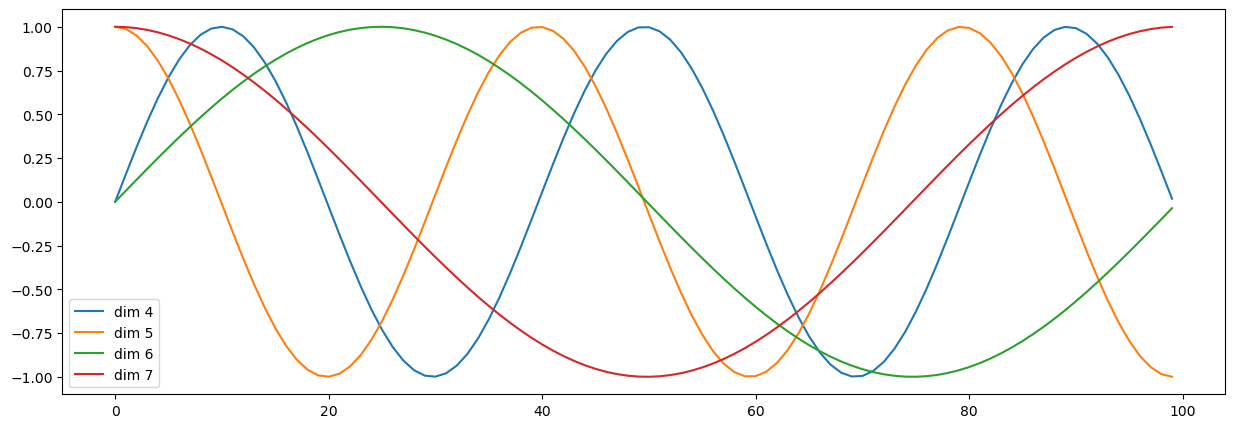

In [13]:
# 一个测试样例
if __name__ == "__main__":
    # 根据位置添加正弦波
    plt.figure(figsize=(15, 5))
    # 设模型维度为20
    pe = PositionalEncoding(20, 0)
    # 执行PE的前向传播，输入张量尺寸为[1, 100, 20]
    y = pe.forward(Variable(torch.zeros(1, 100, 20)))
    # 随便画出几个维度的位置编码
    plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
    plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])
    plt.show()
    None